## Regression in `scikit-learn`

### Goals

- Practice with the `fit` and `predict` interface of sklearn models
- Get a visual sense of how different regression models work.

### Rationale

Neural nets are strong performers for data that lacks clear features. But for well-structured tabular data with meaningful features (or data that can be translated to that form), simple models can sometimes perform very well, and can be much faster and sometimes more interpretable. Even if you plan to fit a neural net model, training a decision tree or random forest first can be a good quick first pass.

The Scikit-Learn (sklearn) `fit`-`predict` interface for modeling has become the *de facto* industry standard for this sort of modeling, so it's highly likely that what you see here will be useful in your future work.

### Documentation

The sklearn documentation is exemplary. See:

- [Linear Models](https://scikit-learn.org/stable/modules/linear_model.html) for, e.g., linear regression
- [Decision Trees](https://scikit-learn.org/stable/modules/tree.html)
- [Ensemble Methods](https://scikit-learn.org/stable/modules/ensemble.html) for, e.g., random forests

## Setup

Let's import necessary modules: *pandas* and NumPy for data wrangling, Matplotlib for plotting, and some sklearn models.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.tree import DecisionTreeRegressor
import sklearn.tree
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

We'll load the data. We're using a dataset of home sale prices from the Ames, Iowa assessor's database, described in [this paper](http://ww2.amstat.org/publications/jse/v19n3/decock.pdf). (DATA 202 students may remember seeing this dataset.)

Pandas (typically imported as `pd`, see above) is a very useful library for working with tabular datasets. We'll see here that we can easily read a CSV file directly off the Internet...

In [2]:
ames = pd.read_csv('https://github.com/kcarnold/AmesHousing/blob/master/data/ames.csv.gz?raw=true', compression="gzip")

The main object from pandas is a `DataFrame`. It holds a table of data:

In [3]:
ames.head()

,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,Utilities,Lot_Config,...,Fence,Misc_Feature,Misc_Val,Mo_Sold,Year_Sold,Sale_Type,Sale_Condition,Sale_Price,Longitude,Latitude
0,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,141,31770,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,No_Fence,NaN,0,5,2010,WD,Normal,215000,-93.619754,42.054035
1,One_Story_1946_and_Newer_All_Styles,Residential_High_Density,80,11622,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,...,Minimum_Privacy,NaN,0,6,2010,WD,Normal,105000,-93.619756,42.053014
2,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,81,14267,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,No_Fence,Gar2,12500,6,2010,WD,Normal,172000,-93.619387,42.052659
3,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,93,11160,Pave,No_Alley_Access,Regular,Lvl,AllPub,Corner,...,No_Fence,NaN,0,4,2010,WD,Normal,244000,-93.617320,42.051245
4,Two_Story_1946_and_Newer,Residential_Low_Density,74,13830,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Inside,...,Minimum_Privacy,NaN,0,3,2010,WD,Normal,189900,-93.638933,42.060899


Each column of data generally has a consistent data type. (Note: `object` columns are the exception. They usually mean "string", but could actually hold any Python object.)

In [4]:
ames.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 81 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   MS_SubClass         2930 non-null   object 
 1   MS_Zoning           2930 non-null   object 
 2   Lot_Frontage        2930 non-null   int64  
 3   Lot_Area            2930 non-null   int64  
 4   Street              2930 non-null   object 
 5   Alley               2930 non-null   object 
 6   Lot_Shape           2930 non-null   object 
 7   Land_Contour        2930 non-null   object 
 8   Utilities           2930 non-null   object 
 9   Lot_Config          2930 non-null   object 
 10  Land_Slope          2930 non-null   object 
 11  Neighborhood        2930 non-null   object 
 12  Condition_1         2930 non-null   object 
 13  Condition_2         2930 non-null   object 
 14  Bldg_Type           2930 non-null   object 
 15  House_Style         2930 non-null   object 
 16  Overal

 It behaves like a dictionary of its columns. Each column is a `Series` object.

In [5]:
type(ames['Sale_Price'])

pandas.core.series.Series

`Series` support broadcast operations, similar to NumPy arrays and Torch `tensor`s; they also have other functionality.

In [6]:
ames['price'] = ames["Sale_Price"] / 100_000 # Make `price` be in units of $100k, to be easier to interpret.


Now we'll look into this dataset:

We'll define some functions to plot the data and models. Since we have latitude and longitude for each home, we can plot this data in 2D with a color for the sale price.

(Sorry, you'll just have to imagine there's a map underneath.)

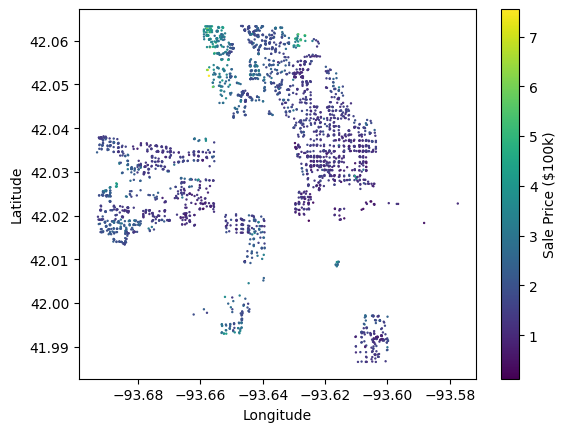

In [7]:
def plot_data():
    # You don't have to know how this function works.
    plt.scatter(ames['Longitude'], ames['Latitude'], c=ames["price"], s=.5)
    plt.xlabel("Longitude"); plt.ylabel("Latitude")
    plt.colorbar(label="Sale Price ($100k)")
plot_data()

We'll try to predict home price based on *location* (which the realtors assure us is the most important factor anyway). So we'll grab the Latitude and Longitude columns of the data. We'll call that input data `X`, by convention. There are several different ways to index into a pandas `DataFrame`; using a `list` gives us a `DataFrame` with just the columns with those names. We'll then access the underlying NumPy data by using `.values`.

In [8]:
X = ames[['Longitude', 'Latitude']].values
X.shape

(2930, 2)

Our target, called `y` by convention, will be the home price (we'll soon introduce a different *y*, but start with this one).

In [9]:
y = ames['price'].values
y.shape

(2930,)

Notice that `X` has two axes and thus is written in uppercase; `y` has 1 and thus is written in lowercase. (This is `sklearn` convention; other libraries are less consistent about this.)

Now let's split the data into a `train` and `valid` set (which sklearn calls train-*test*, but that's fine). `random_state` is how `sklearn` specifies the random seed (it's actually slightly more flexible than a seed).

In [10]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=.2, random_state=42)

We'll verify that the shapes make sense. Note how many items are in each of the sets.

In [11]:
X_train.shape, y_train.shape

((2344, 2), (2344,))

In [12]:
X_valid.shape, y_valid.shape

((586, 2), (586,))

Here's a function to plot our regression model in "data space" (i.e., what it would predict everywhere on the map).

This function is pretty customized to our specific use case, though you can get inspiration from it for use in other situations.

In [13]:
def plot_model(clf, fig=None):
    # Compute extents
    lat_min = ames.Latitude.min()
    lat_max = ames.Latitude.max()
    lon_min = ames.Longitude.min()
    lon_max = ames.Longitude.max()
    price_min = ames.price.min()
    price_max = ames.price.max()

    # Ask the classifier for predictions on a grid
    xx, yy = np.meshgrid(np.linspace(lon_min, lon_max, 250), np.linspace(lat_min, lat_max, 250))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    if fig is None:
        fig = plt.figure(figsize=plt.figaspect(2))

    # Left side: show the predictions in 2D. Superimpose the original data.
    ax = fig.add_subplot(2, 1, 1)
    surf = ax.contourf(xx, yy, Z, alpha=.5, cmap=plt.cm.viridis, vmin=price_min, vmax=price_max)
    ax.scatter(ames['Longitude'], ames['Latitude'], c=ames["price"], s=1, cmap='viridis', vmin=price_min, vmax=price_max)
    ax.set(xlabel="Longitude", ylabel="Latitude", title="2D contour view")
    fig.colorbar(surf, label="Sale Price ($100k)")

    # Right side: show the predictions in 3D
    ax = fig.add_subplot(2, 1, 2, projection='3d')
    ax.plot_surface(xx, yy, Z, alpha=.5, cmap=plt.cm.viridis, vmin=price_min, vmax=price_max)
    #ax.scatter(ames['Longitude'], ames['Latitude'], c=ames["price"], s=1, cmap='viridis', vmin=price_min, vmax=price_max)
    ax.set(title="3D view")

## Task

### Part A: Linear regression

Step A1: **Fit a linear regression model (call it `linreg`) to the training set (`X_train`, `y_train`).**

In [14]:
linreg = LinearRegression().fit(X_train, y_train)
print("Prediction equation:")
print('y_pred = '
    + ' + ' .join(f'{coef:.3f} * {name}' for coef, name in zip(linreg.coef_, ['Longitude', 'Latitude']))
    + f' + {linreg.intercept_:.3f}')

Prediction equation:
y_pred = -7.955 * Longitude + 11.886 * Latitude + -1242.742


Here are the Latitude and Longitude coordinates of the first home in the validation set. **Compute what the model would predict for this home**, based on the prediction equation shown above.

In [15]:
example_home = X_valid[0]
example_home

array([-93.621065,  42.029038])

Now we'll **plot the model's predictions in data space.** The code for step is filled in for you because there's not a generic way to do this; our approach here is customized to our particular model and task so you don't have to understand the details of how it works.

The main thing to observe here is **what shapes do you see**. Think about why you might see those shapes in light of the prediction equation.

**Note**: The first plot is a *contour plot* (aka contour graph). If you're not familiar with this style of visualization, look at the Wikipedia page or the Khan Academy video. It's like a topological map; the third dimension in this case is the model's predicted price. The lines that you see are like contour lines; the linear regression is actually quite smooth (too smooth?). The second plot shows the prediction in 3D space, which may make it clearer.

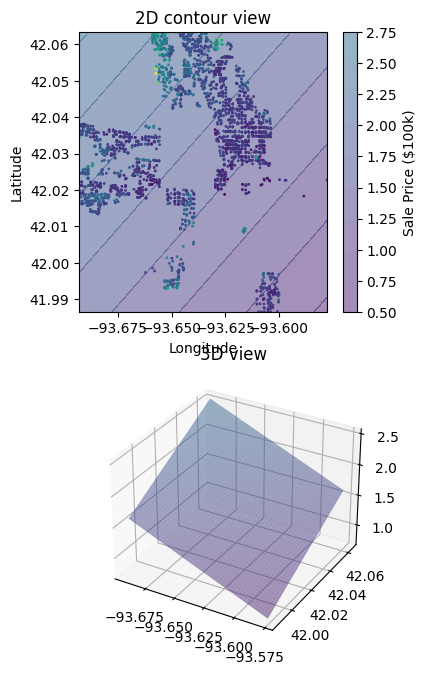

In [16]:
plot_model(linreg)

Step A3: **Compute the model's predictions on the validation set (call them `y_pred`). What was the model's prediction for the first house in the validation set?** (did you get it right in the previous question?) **How does that compare with the actual price for that home?**

In [17]:
y_pred = linreg.predict(X_valid)
y_pred


array([1.55432848, 1.87288097, 1.84309863, 2.002935  , 1.53631185,
       2.14579607, 1.51662181, 1.84115597, 1.90102897, 2.21029996,
       1.94730741, 1.88508264, 0.97646365, 1.80253108, 1.6144321 ,
       1.9920874 , 1.7534695 , 2.18861631, 0.99634917, 1.7263617 ,
       2.06948862, 1.93905542, 1.96657001, 1.96020087, 2.05520427,
       1.88915864, 1.37518907, 2.11401391, 1.905041  , 2.03706838,
       1.87489787, 1.69104368, 1.37991372, 1.52852558, 1.55137706,
       0.97218488, 2.14209579, 2.19693724, 2.18775277, 1.96974492,
       2.24054404, 1.88053853, 1.5562634 , 1.59109482, 1.77634751,
       2.19188087, 1.90040195, 1.90803437, 1.84866228, 1.54516434,
       1.92132813, 1.64538052, 1.85832909, 1.58688483, 2.03925581,
       1.95316494, 2.03475882, 1.67180788, 1.89337177, 1.86999035,
       1.61430899, 2.10135354, 1.54758972, 2.25058279, 2.06612   ,
       1.51623886, 1.89992845, 1.95706293, 2.15134426, 2.13053026,
       1.56142304, 2.03996949, 1.97689061, 1.56425645, 2.02638

What was the model's prediction for the first house in the validation set? 

1.55432848

How does that compare with the actual price for that home?

1.61   so it was .06 different which is pretty good 

Step A4: **Compute and show the mean squared error, the mean absolute error, and the r2 score for the validation set.**

- You may use the `mean_absolute_error`, `mean_squared_error`, and `r2_score` functions (imported from `sklearn.metrics` above).
- Use the predictions you already made above.
- Use Shift-TAB or `?` to get the documentation for these functions to ensure you're passing the arguments in the correct order.

In [18]:
# your code here
mae = mean_absolute_error(y_valid, y_pred)
mse = mean_squared_error(y_valid, y_pred)
r2 = r2_score(y_valid, y_pred)

print(f"Mean {mse}")

Mean 0.6786574994305143


For convenience, sklearn models have a `.score()` method, which computes the predictions and error metrics at the same time. Look at the results below: **which error metric does `.score()` seem to use for regression tasks**?

In [19]:
print(f"Training score: {linreg.score(X_train, y_train):.3f}")
print(f"Validation score: {linreg.score(X_valid, y_valid):.3f}")

Training score: 0.147
Validation score: 0.154


*Reflect*:

1. How does a linear regression make a prediction?

with a linear model

2. Is a linear regression able to capture that homes are typically more expensive on one *side of town* than the other? (Which side?) Why or why not?

yes top left, bc of slope

3. Is a linear regression able to capture that homes in one *neighborhood* are typically more expensive than those in adjacent neighborhoods? Why or why not?

not necessarily, it just shows that the top left part of town is more expensive, because it has to be linear, so it lacks complexity


### Part B: Decision tree regression

Step B1: **Fit a decision tree model (call it `dtree_reg`) to the training set (`X_train`, `y_train`).**

We'll use a small `max_depth` to be able to plot the tree. We'll then fit another one with full depth.

Notice how the tree makes its prediction starting at the top (root) and checking one feature at a time. If the check is `True`, it goes left; otherwise, it goes right. When it hits a node with no check (a "leaf"), it predicts the value stored there. (Think: how do you think it might have computed that value?)

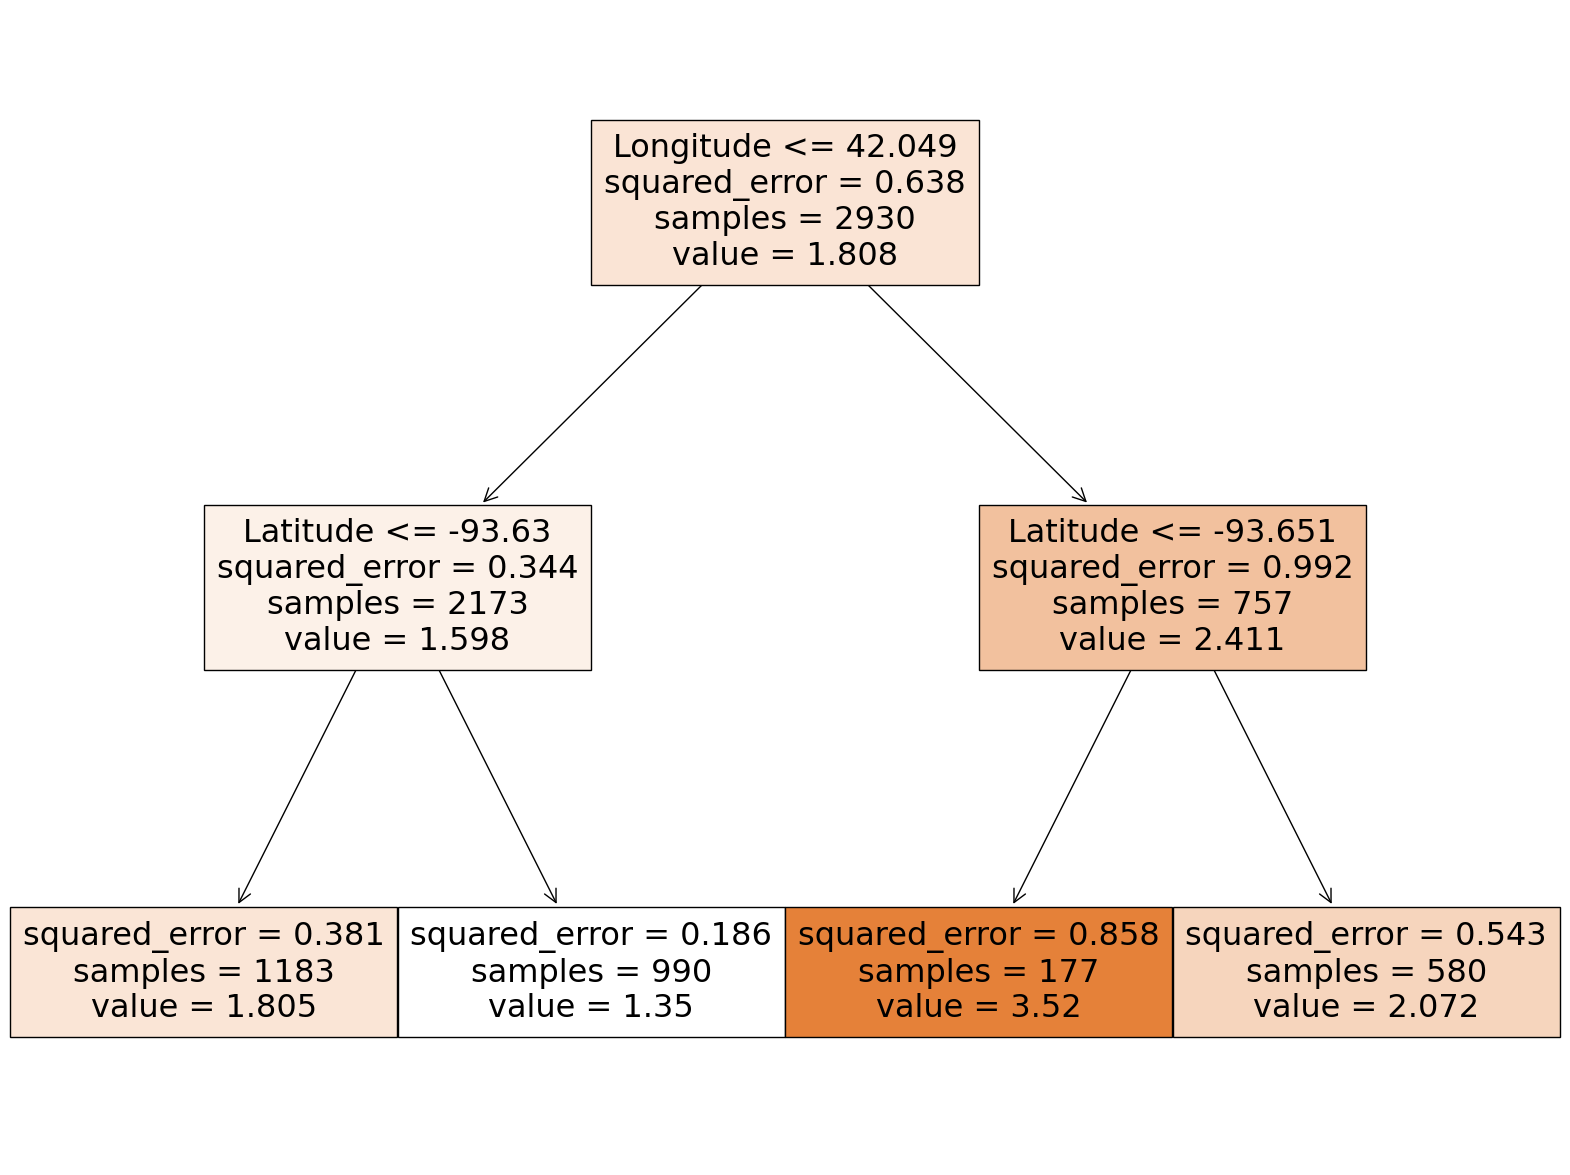

In [20]:
dtree_reg_small = DecisionTreeRegressor(max_depth=2).fit(X, y)
plt.figure(figsize=(20, 15))
sklearn.tree.plot_tree(dtree_reg_small, feature_names=["Latitude", "Longitude"], filled=True);

**Exercise**: compute by hand the tree's prediction for the same first house in the validation set.

value = 1.805

In [21]:
X_valid


array([[-93.621065,  42.029038],
       [-93.627103,  42.051798],
       [-93.672379,  42.01899 ],
       ...,
       [-93.651014,  42.057277],
       [-93.677545,  42.020703],
       [-93.677407,  42.021244]])

Now let's let the tree grow as big as it wants.

In [22]:
dtree_reg = DecisionTreeRegressor().fit(X, y)


If the tree is big, the graphic may get unreadable. A text export may be easier to read:

In [23]:
print(sklearn.tree.export_text(dtree_reg, feature_names=["Latitude", "Longitude"], max_depth=2))

|--- Longitude <= 42.05
|   |--- Latitude <= -93.63
|   |   |--- Longitude <= 42.00
|   |   |   |--- truncated branch of depth 10
|   |   |--- Longitude >  42.00
|   |   |   |--- truncated branch of depth 24
|   |--- Latitude >  -93.63
|   |   |--- Longitude <= 42.01
|   |   |   |--- truncated branch of depth 17
|   |   |--- Longitude >  42.01
|   |   |   |--- truncated branch of depth 30
|--- Longitude >  42.05
|   |--- Latitude <= -93.65
|   |   |--- Latitude <= -93.65
|   |   |   |--- truncated branch of depth 12
|   |   |--- Latitude >  -93.65
|   |   |   |--- truncated branch of depth 15
|   |--- Latitude >  -93.65
|   |   |--- Latitude <= -93.63
|   |   |   |--- truncated branch of depth 23
|   |   |--- Latitude >  -93.63
|   |   |   |--- truncated branch of depth 18



Step B2: **Plot the decision tree model in data space**. Observe what shapes you see.

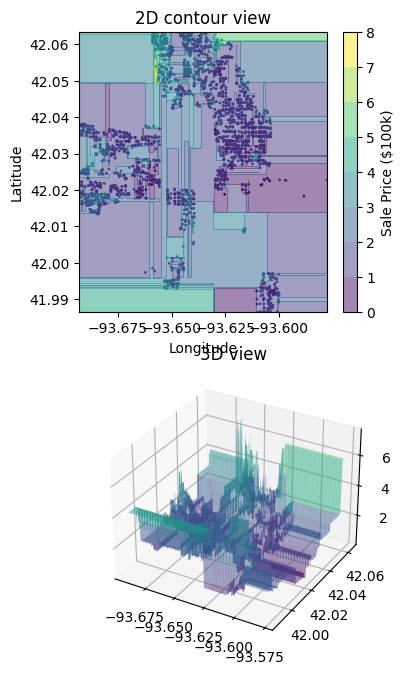

In [24]:
plot_model(dtree_reg)

there are a lot of rectangles, its richer on the sides

### Part C: Random Forest regression

Random Forests take random subsets of the data and fit decision trees to each one. As each tree is fit, it also considers only a random subset of features for each decision. The combination of these two reduces the *variance* of the model, that is, how much the model's predictions change if it's fit on different subsets of data.

**Fit a random forest regression model to this data.** Use the default hyperparameters.

In [25]:
rf_reg = RandomForestRegressor().fit(X, y)
print(f"We just fit a random forest with {rf_reg.n_estimators} trees.")

We just fit a random forest with 100 trees.


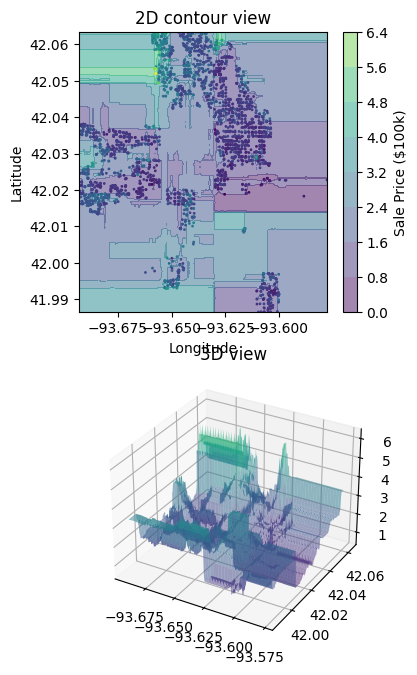

In [26]:
plot_model(rf_reg)

Note: you can use code like this to show all of the different trees in the forest. It may or may not work in your computer, though.

In [27]:
if False:
    from matplotlib.animation import FuncAnimation
    from IPython.display import HTML
    def frame(i):
        plt.clf()
        plot_model(rf_reg.estimators_[i], fig=fig)
        plt.title(f"Tree {i:03d}")
    fig = plt.figure(figsize=(16, 10))
    anim = FuncAnimation(fig=fig, func=frame, frames=min(10, len(rf_reg.estimators_)))
    # One of these two should work:
    display(HTML(anim.to_html5_video()))
    #display(HTML(anim.to_jshtml()))


Again, compute the predictions and errors.

In [28]:
rf_reg.predict(X)


array([1.843735, 1.1934  , 1.6691  , ..., 1.286105, 1.7544  , 2.065   ])

## Analysis

Q1: Describe the basic steps for fitting a model in sklearn and making predictions.

train test split, then fit to the training sets instead of the test sets


Q2: Describe parameters that the `fit` method takes. For each one, describe its purpose and its shape.

it takes X and y, which X is the lat and longitude of where the houses are, and y is the outcome of how much the house costs

Q3: Describe, qualitatively, what each of the 3 models here looks like in data space. Describe a characteristic of the visualization that would let you tell immediately which type of model it is from. You might notice differences in the shapes of the boundaries it draws and, if you look more closely, a difference in how the boundaries relate to the data.

the linear model is very flat and smooth

the decision tree model is very bumpy and irregular

the random forest regression model is a series of very bumpy and irregular models


Q4: Describe, quantitatively, how the performance of the different models compares. Which performs best? Which performs worst? Explain how the performance numbers make sense in light of the data-space plots.

In [29]:
rf = ((y_valid - rf_reg.predict(X_valid)) ** 2).mean()
dtree = ((y_valid - dtree_reg.predict(X_valid)) ** 2).mean()
lr = ((y_valid - linreg.predict(X_valid)) ** 2).mean()

f"RF: {rf} DTree: {dtree} Linreg: {lr}"

'RF: 0.0260434502300605 DTree: 3.402524630842097e-05 Linreg: 0.6786574994305143'

The decision tree preformed the best, it has the lowest MSE, while linear regression preformed the worst with the highest MSE.



## Extension

*optional*

1. Compute the loss on the *training* set for each of these models. Can that help you tell whether the model overfit or not?
2. Try using more features in the dataset. How well can you predict the price? Be careful about *categorical* features. (Note that you won't be able to use `plot_model` as-is if you add additional features.)